# Optimización de Portafolio en Python

Optimizacion de un Portafolio con Oro, Nikkei 225 y SP-500 como activos solidos en un entorno de alta inflación

### Obtención de Datos e Importación de Librerias

Cargar Yahoo Finance, matplotlib y numpy; Descargar datos de precios desde el 1 de enero de 2014 al 1 de enero de 2024

In [120]:
import yfinance as yf
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from scipy.optimize import minimize

data = yf.download(['GC=F', '^N225', '^GSPC'], start='2014-01-01', end='2024-01-01', auto_adjust=False)['Close']

[*********************100%***********************]  3 of 3 completed


In [121]:
data.head()

Ticker,GC=F,^GSPC,^N225
Date,,,
2014-01-02,1225.000000,1831.979980,NaN
2014-01-03,1238.400024,1831.369995,NaN
2014-01-06,1237.800049,1826.770020,15908.879883
2014-01-07,1229.400024,1837.880005,15814.370117
2014-01-08,1225.300049,1837.489990,16121.450195


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

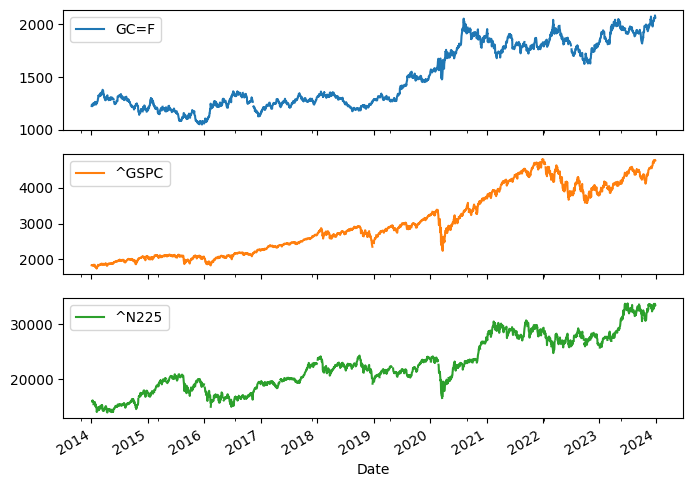

In [122]:
data.plot(figsize = (8,6), subplots=True)

#### Calculando Retornos

In [123]:
data.pct_change()

Ticker,GC=F,^GSPC,^N225
Date,,,
2014-01-02,NaN,NaN,NaN
2014-01-03,0.010939,-0.000333,NaN
2014-01-06,-0.000484,-0.002512,NaN
2014-01-07,-0.006786,0.006082,-0.005941
2014-01-08,-0.003335,-0.000212,0.019418
...,...,...,...
2023-12-25,0.000000,0.000000,0.002562
2023-12-26,0.000535,0.004232,0.001558
2023-12-27,0.011515,0.001430,0.011271


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

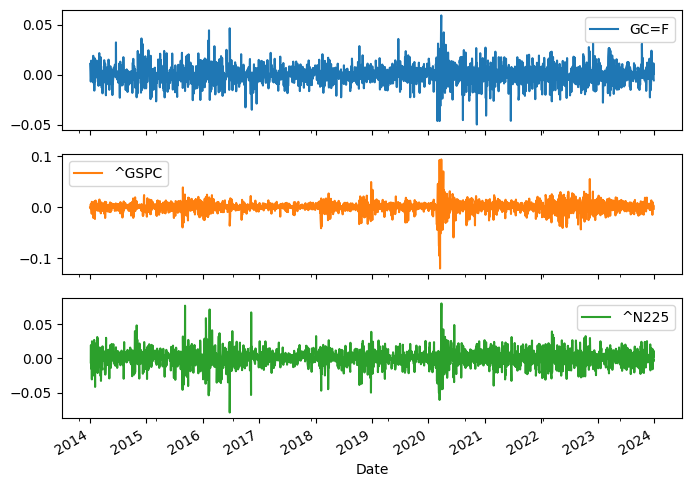

In [124]:
data.pct_change().plot(figsize = (8,6), subplots=True)

In [125]:
#Calcular Retornos Diarios
retornos_diarios = data.pct_change()

#Calcular Rendimiento Anualizado
rendimiento_anualizado = (1 + retornos_diarios.mean()) ** 252 - 1

#Mostrar Resultado
print("Rendimiento Anual: {0}".format(rendimiento_anualizado))

Rendimiento Anual: Ticker
GC=F     0.062752
^GSPC    0.114258
^N225    0.095263
dtype: float64


In [126]:
#Calcular Volatilidad
volatilidad_anualizada = retornos_diarios.std() * (252 ** 0.5)

#Mostrar Resultado
print("Volatilidad Anual: {0}".format(volatilidad_anualizada))

Volatilidad Anual: Ticker
GC=F     0.143555
^GSPC    0.174592
^N225    0.193716
dtype: float64


### Optimizacion de Portafolios

In [127]:
#Calcular la Matriz de Covarianza

covarianzas_diarias = retornos_diarios.cov()
covarianza_anualizada = covarianzas_diarias * 252


In [128]:
#Generar Portafolios

rendimientos = []
riesgos = []
portafolios = []

pesos_oro = np.linspace(0, 1, 101)
pesos_nikkei = np.linspace(0, 1, 101)
for po in pesos_oro:
    for pp in pesos_nikkei:
        w1 = po
        w2 = pp
        w3 = 1 - w1 - w2
            
        pesos = np.array([w1, w2, w3])

        #Calcular Rendimiento
        rendimiento = np.dot(pesos, rendimiento_anualizado)

        #Calcular Riesgo 
        riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianza_anualizada, pesos)))

        #Guardar Resultados
        rendimientos.append(rendimiento)
        riesgos.append(riesgo)
        portafolios.append(pesos)

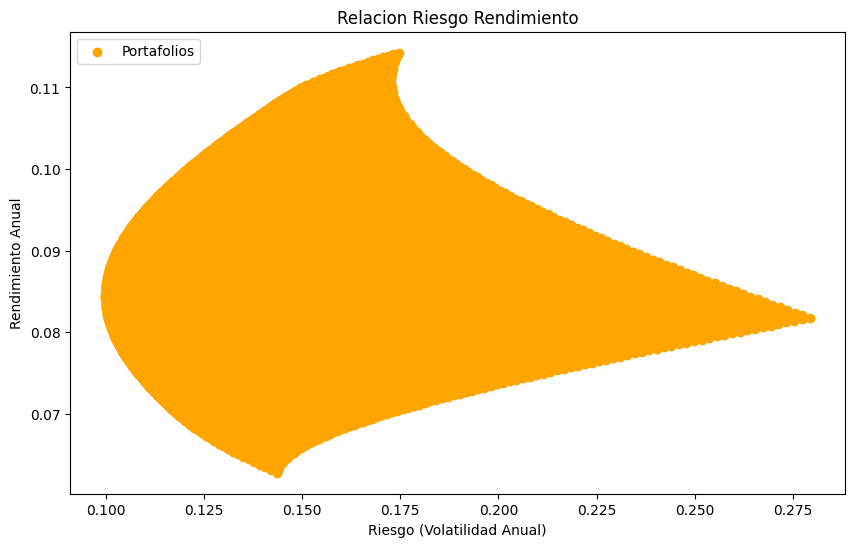

In [129]:
#Graficar Frontera Eficiente
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Volatibilidad Mínima

In [130]:
#Función Objetivo: Minimizar la varianza del Portafolio

def varianza_minima(w, cov):
    return np.dot(w.T, np.dot(cov, w))

In [131]:
#Restricciones: Pesos deben sumar 1

restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) -1}
)

In [132]:
#limites: deben estar entre 0 y 1
limites = [(0, 1) for _ in range(len(covarianzas_diarias))]

In [133]:
#Pesos Iniciales
pesos_iniciales = np.array([0.33, 0.33, 0.34])

In [134]:
#Optimización
resultado = minimize(
    varianza_minima,
    pesos_iniciales,
    args=(covarianza_anualizada,),
    constraints = restricciones, 
    bounds = limites,
    method = "SLSQP"
)

In [135]:
#Peso Varianza Minima
pesos_min_var = resultado.x
print("Pesos Varianza Minima: {0}".format(pesos_min_var))

Pesos Varianza Minima: [0.48880568 0.28776822 0.2234261 ]


In [136]:
rendimiento_min_var = np.dot(pesos_min_var, rendimiento_anualizado)
riesgo_min_var = np.sqrt(np.dot(pesos_min_var.T, np.dot(covarianza_anualizada, pesos_min_var)))

print("Rendimiento: {0}".format(rendimiento_min_var))
print("Riesgo: {0}".format(riesgo_min_var))

Rendimiento: 0.08483742813393387
Riesgo: 0.09988947033196137


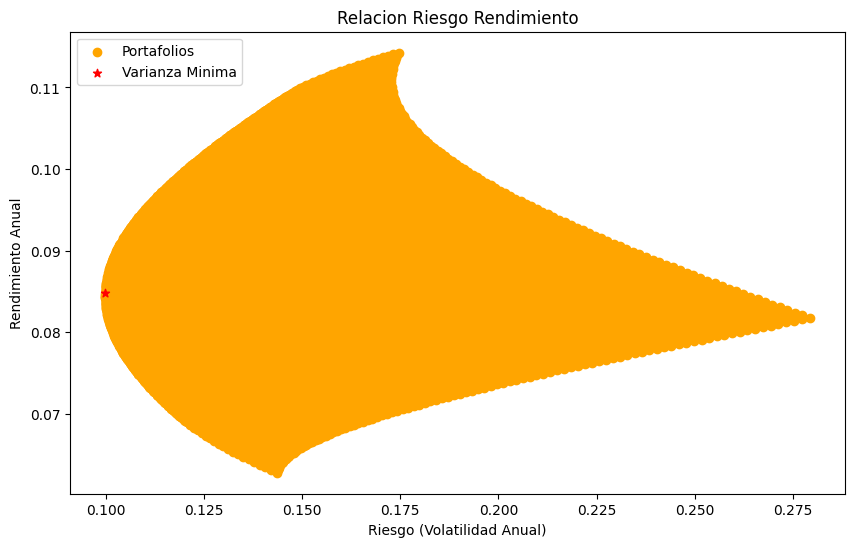

In [137]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Criterio de Asimetría y Curtosis

Se buscar maximizar asimetría y minimizar Curtosis para encontrar altos retornos con el menor riesgo posible

In [138]:
#Calculo de Asumetría
def calcular_asimetria(y, pesos):
    portafolio_retorno = np.dot(y, pesos)
    return np.mean((portafolio_retorno - np.mean(portafolio_retorno))**3) / (np.std(portafolio_retorno) * (252 ** 0.5)) ** 3

#Calculo de Curtosis
def calcular_curtosis(y, pesos):
    portafolio_retorno = np.dot(y, pesos)
    return np.mean((portafolio_retorno - np.mean(portafolio_retorno))**4) / (np.std(portafolio_retorno) * (252 ** 0.5)) ** 4

In [139]:
#Definir funcion objetivo
def objetivo(w, y, lambda_asimetria = 1, lambda_curtosis = 1):
    asimetria = calcular_asimetria(y, w)
    curtosis = calcular_curtosis(y, w)
    return -lambda_asimetria * asimetria + lambda_curtosis * curtosis

In [140]:
#Restriccion de Pesos
def restriccion_suma_pesos(w):
    return np.sum(w) - 1

#Restriccion de Pesos Positivos
def restriccion_pesos_positivos(w):
    return w

In [141]:
retornos_diarios = data.pct_change().dropna()
y = retornos_diarios.values

resultado = minimize(
    objetivo,
    pesos_iniciales,
    args=(y,),
    method="SLSQP",
    bounds=limites,
    constraints=restricciones
)

pesos_asimetria = resultado.x
print("Pesos optimos para Criterio de Asimetría y Curtosis: {0}".format(pesos_asimetria))


Pesos optimos para Criterio de Asimetría y Curtosis: [0.33 0.33 0.34]


In [142]:
rendimiento_asimetria = np.dot(pesos_asimetria, rendimiento_anualizado)
riesgo_asimetria = np.sqrt(np.dot(pesos_asimetria.T, np.dot(covarianza_anualizada, pesos_asimetria)))

print("Rendimiento Asimetría: {0}".format(rendimiento_asimetria))
print("Riesgo Asimetría: {0}".format(riesgo_asimetria))

Rendimiento Asimetría: 0.09080253316724186
Riesgo Asimetría: 0.10565152473311062


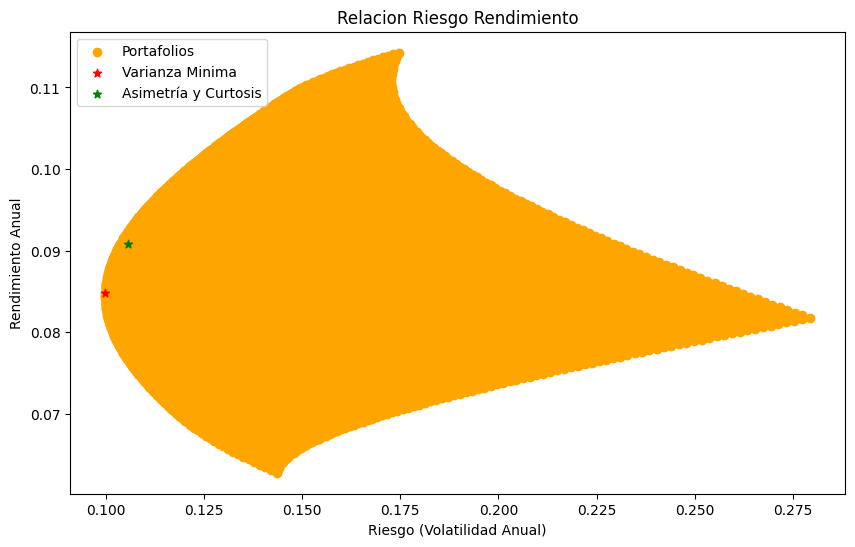

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")
plt.scatter(riesgo_asimetria, rendimiento_asimetria, label="Asimetría y Curtosis", color="green", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Ratio de Sharpe

In [144]:
#Tasa Libre de Riesgo 
tasa_libre_riesgo = 0.03

def rendimiento_riesgo(pesos, retornos, covarianzas):
    rendimiento = np.dot(pesos, retornos)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas, pesos)))
    return rendimiento, riesgo

def ratio_sharpe(pesos, retornos, covarianzas, tasa_libre_riesgo):
    rendimiento, riesgo = rendimiento_riesgo(pesos, retornos, covarianzas)
    return - (rendimiento - tasa_libre_riesgo) / riesgo

In [145]:
#Optimizacion

resultado = minimize(
    ratio_sharpe,
    pesos_iniciales,
    args=(rendimiento_anualizado, covarianza_anualizada, tasa_libre_riesgo),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

pesos_sharpe = resultado.x 
rendimiento_sharpe, riesgo_sharpe = rendimiento_riesgo(pesos_sharpe, rendimiento_anualizado, covarianza_anualizada)
print("Pesos Optimos Sharpe {0}".format(pesos_sharpe))
print("Rendimiento Sharpe {0}".format(rendimiento_sharpe))
print("Riesgo Sharpe {0}".format(riesgo_sharpe))

Pesos Optimos Sharpe [0.29969145 0.45163219 0.24867637]
Rendimiento Sharpe 0.09409828461640428
Riesgo Sharpe 0.10833999140725716


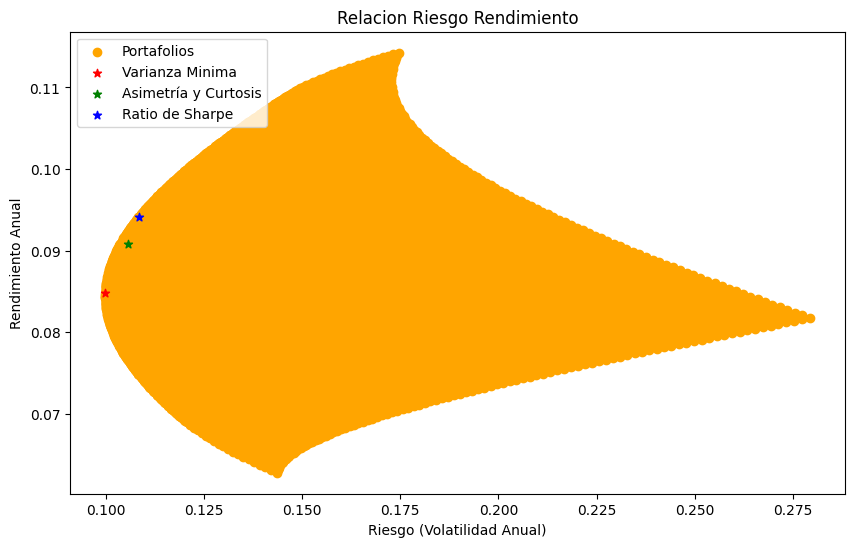

In [146]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")
plt.scatter(riesgo_asimetria, rendimiento_asimetria, label="Asimetría y Curtosis", color="green", marker="*")
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label="Ratio de Sharpe", color="blue", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Ratio de Sortino

In [147]:
#Funcion para calcular el riesgo de perdidas
def downside_risk(pesos, retornos):
    rendimiento_portafolio = np.dot(retornos, pesos)

    #Calculo Rendimiento Negativo
    downside = rendimiento_portafolio[rendimiento_portafolio < 0]
    if len(downside) == 0:
        return 0
    
    return np.std(downside)

#Funcion Ratio Sortino
def ratio_sortino(pesos, retornos, tasa_libre_riesgo):
    rendimiento = (1 + np.dot(pesos, retornos.mean())) ** 252
    downside = downside_risk(pesos, retornos)
    if downside == 0:
        return np.inf 
    
    return -(rendimiento - tasa_libre_riesgo) / downside


In [148]:
#Optimización
resultado = minimize(
    ratio_sortino,
    pesos_iniciales,
    args=(retornos_diarios, tasa_libre_riesgo),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

pesos_sortino = resultado.x
rendimiento_sortino, riesgo_sortino = rendimiento_riesgo(pesos_sortino, rendimiento_anualizado, covarianza_anualizada)
print("Pesos Optimos Sortino {0}".format(pesos_sortino))
print("Rendimiento Sortino {0}".format(rendimiento_sortino))
print("Riesgo Sortino {0}".format(riesgo_sortino))

Pesos Optimos Sortino [0.52511788 0.2067008  0.26818132]
Rendimiento Sortino 0.0821170168872295
Riesgo Sortino 0.10074474938989013


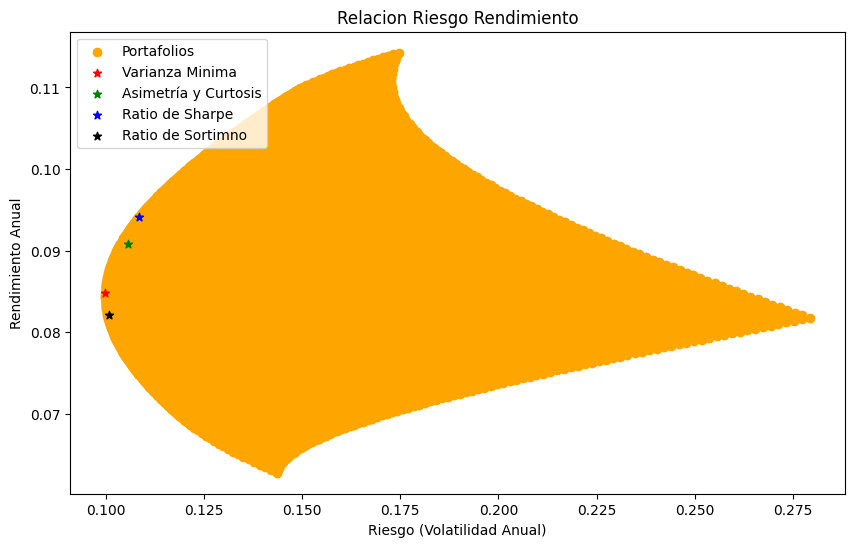

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")
plt.scatter(riesgo_asimetria, rendimiento_asimetria, label="Asimetría y Curtosis", color="green", marker="*")
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label="Ratio de Sharpe", color="blue", marker="*")
plt.scatter(riesgo_sortino, rendimiento_sortino, label="Ratio de Sortimno", color="black", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Comparación Rendimiento Historico

In [150]:
historico = pd.DataFrame()

historico['Minima Varianza'] = data.pct_change().dot(pesos_min_var)
historico['Asimetria'] = data.pct_change().dot(pesos_asimetria)
historico['Ratio Sharpe'] = data.pct_change().dot(pesos_sharpe)
historico['Ratio Sortino'] = data.pct_change().dot(pesos_sortino)

historico = historico.dropna()
historico.head()

,Minima Varianza,Asimetria,Ratio Sharpe,Ratio Sortino
Date,,,,
2014-01-07,-0.002894,-0.002252,-0.000764,-0.003900
2014-01-08,0.002647,0.005431,0.003733,0.003412
2014-01-09,-0.001646,-0.003893,-0.002584,-0.002225
2014-01-10,0.008029,0.006111,0.005781,0.008445
2014-01-13,-0.001972,-0.003038,-0.004670,-0.000830


C:\Users\AXEL ALEMAN\AppData\Local\Temp\ipykernel_11076\2102786670.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


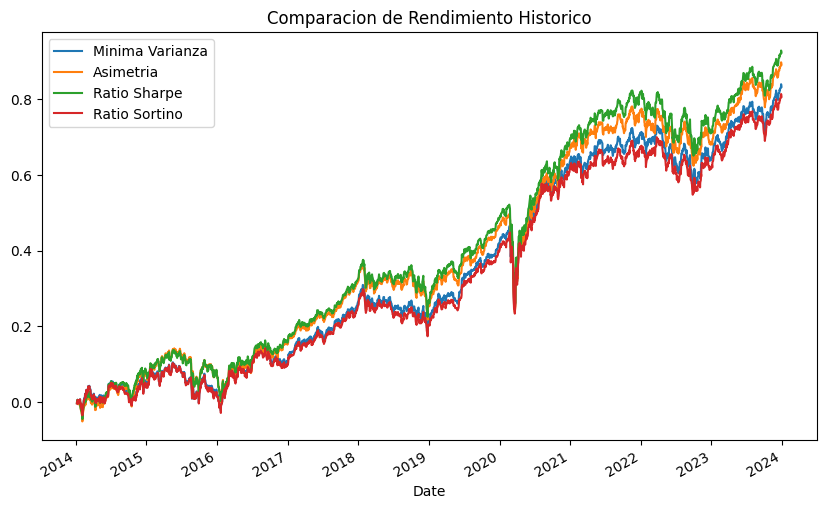

In [151]:
#Graficar

fig, ax = plt.subplots(figsize=(10,6))
historico.cumsum().plot(ax=ax)
ax.set_title("Comparacion de Rendimiento Historico")
fig.show()

In [152]:
print("Rendimiento Final")
print(historico.cumsum().tail(1))

Rendimiento Final
            Minima Varianza  Asimetria  Ratio Sharpe  Ratio Sortino
Date                                                               
2023-12-29         0.832316   0.890806      0.922499       0.806034


### Comparación de Rendimiento Actual

In [153]:
new_data = yf.download(['GC=F', '^N225', '^GSPC'], start='2024-01-01', end='2026-02-01', auto_adjust=False)['Close']

[*********************100%***********************]  3 of 3 completed


In [154]:
actual = pd.DataFrame()

actual['Minima Varianza'] = new_data.pct_change().dot(pesos_min_var)
actual['Asimetria'] = new_data.pct_change().dot(pesos_asimetria)
actual['Ratio Sharpe'] = new_data.pct_change().dot(pesos_sharpe)
actual['Ratio Sortino'] = new_data.pct_change().dot(pesos_sortino)

actual = actual.dropna()
actual.head()

,Minima Varianza,Asimetria,Ratio Sharpe,Ratio Sortino
Date,,,,
2024-01-05,0.001148,0.001529,0.001505,0.001121
2024-01-08,0.000280,0.002105,0.004056,-0.001145
2024-01-09,0.002109,0.003409,0.002177,0.002742
2024-01-10,0.004987,0.007937,0.006861,0.005343
2024-01-11,0.001963,0.004574,0.002991,0.002675


C:\Users\AXEL ALEMAN\AppData\Local\Temp\ipykernel_11076\2543245500.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


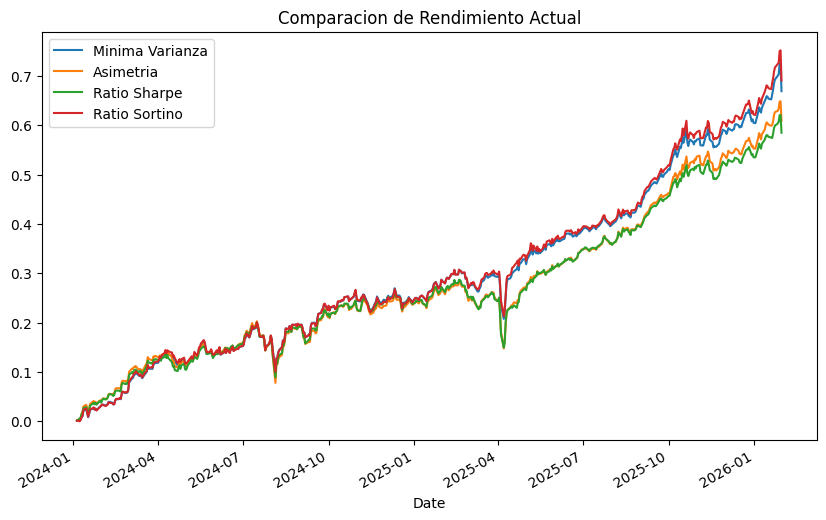

In [155]:
#Graficar

fig, ax = plt.subplots(figsize=(10,6))
actual.cumsum().plot(ax=ax)
ax.set_title("Comparacion de Rendimiento Actual")
fig.show()

In [156]:
print("Rendimiento Final")
print(historico.cumsum().tail(1))

Rendimiento Final
            Minima Varianza  Asimetria  Ratio Sharpe  Ratio Sortino
Date                                                               
2023-12-29         0.832316   0.890806      0.922499       0.806034
